LSTM NVIDIA Stock Predection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
data = yf.download(tickers = 'NVDA', start = '2003-03-11',end = '2024-04-18')
data.tail(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-11,874.200012,907.390015,869.260010,906.159973,906.159973,43163700
2024-04-12,896.989990,901.750000,875.299988,881.859985,881.859985,42488900
2024-04-15,890.979980,906.130005,859.289978,860.010010,860.010010,44307700
2024-04-16,864.330017,881.179993,860.640015,874.150024,874.150024,37045300
2024-04-17,883.400024,887.750000,839.500000,840.349976,840.349976,49540000


In [2]:
# Adding indicators
data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=100)
data['EMAS']=ta.ema(data.Close, length=150)

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)


In [3]:
data_set = data.iloc[:, 0:10]#.values
pd.set_option('display.max_columns', None)

data_set.tail(5)

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,TargetNextClose
5158,839.260010,874.000000,837.090027,870.390015,52.059498,877.443328,707.609283,638.213585,906.159973
5159,874.200012,907.390015,869.260010,906.159973,58.504801,880.178247,711.540980,641.762543,881.859985
5160,896.989990,901.750000,875.299988,881.859985,53.290004,880.338413,714.913634,644.942642,860.010010
5161,890.979980,906.130005,859.289978,860.010010,49.075749,878.402374,717.786829,647.791216,874.150024
5162,864.330017,881.179993,860.640015,874.150024,51.722898,877.997388,720.883130,650.789346,840.349976


In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

[[6.11706663e-04 5.80582405e-04 6.42174874e-04 ... 3.42226434e-04
  3.03197717e-04 6.01517815e-04]
 [6.30849274e-04 6.14834651e-04 6.68040545e-04 ... 3.38906839e-04
  3.00007118e-04 6.26481465e-04]
 [6.13446188e-04 6.15690660e-04 6.52877778e-04 ... 3.36363881e-04
  2.97385669e-04 6.08764687e-04]
 ...
 [9.35763025e-01 9.25757390e-01 9.35996586e-01 ... 9.91704429e-01
  9.90997057e-01 9.05182673e-01]
 [9.29487590e-01 9.30258193e-01 9.18861210e-01 ... 9.95697194e-01
  9.95383384e-01 9.20077888e-01]
 [9.01660664e-01 9.04620075e-01 9.20306143e-01 ... 1.00000000e+00
  1.00000000e+00 8.84472622e-01]]


In [5]:
print(data_set_scaled[0].size)

9


In [6]:
# multiple feature from data provided to the model
X = []

backcandles = 34
print(data_set_scaled.shape[0])
for j in range(8):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-2])
y=np.reshape(yi,(len(yi),1))
#print(X)
print(X.shape)
#print(y)
print(y.shape)

5163
(5129, 34, 8)
(5129, 1)


In [7]:

# split data into train test sets

splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

4103
(4103, 34, 8)
(1026, 34, 8)
(4103, 1)
(1026, 1)
[[0.00032073]
 [0.00032517]
 [0.00032941]
 ...
 [0.08455227]
 [0.08451229]
 [0.08439916]]


Model1 
Input Layer 8 inputs 
1 LSTM Layer with 150 neurons
1 dense layer 



In [8]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model1 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model1.compile(optimizer=adam, loss='mse')
model1.fit(x=X_train, y=y_train, batch_size=15, epochs=34, shuffle=True, validation_split = 0.1)

Epoch 1/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 2.1812e-04 - val_loss: 1.4121e-04
Epoch 2/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 1.5757e-06 - val_loss: 1.1975e-04
Epoch 3/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 1.0478e-06 - val_loss: 6.5173e-05
Epoch 4/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 9.3559e-07 - val_loss: 5.8379e-05
Epoch 5/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 4.6413e-07 - val_loss: 4.0986e-05
Epoch 6/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 4.6539e-07 - val_loss: 3.9885e-05
Epoch 7/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 5.1121e-07 - val_loss: 1.4469e-05
Epoch 8/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.7124e-06 - val_loss: 6.0177e-05
Epoch 9/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9.2820e-07 - val_loss: 1.3924e-05
Epoch 10/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 6.3609e-07 - val_loss: 2.1022e-05
Epoch 11/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/

In [9]:
y_pred = model1.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[0.07930625] [0.08433928]
[0.07920237] [0.08424338]
[0.07924733] [0.08418413]
[0.07908388] [0.08431173]
[0.07954432] [0.08441948]
[0.07996033] [0.08458505]
[0.08029623] [0.08472544]
[0.08055094] [0.08492954]
[0.08086821] [0.08512078]
[0.0812408] [0.08520482]


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions
y_train_pred_1 = model1.predict(X_train)
y_test_pred_1 = model1.predict(X_test)

# Calculate metrics
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Training Metrics Model1:")
print("MSE Model1: ", mse_train)
print("RMSE Model1: ", rmse_train)
print("MAE Model1: ", mae_train)
print("R2 Model1: ", r2_train)

print("\nTesting Metrics Model1:")
print("MSE Model1: ", mse_test)
print("RMSE Model1: ", rmse_test)
print("MAE Model1: ", mae_test)
print("R2 Model1: ", r2_test)


129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Training Metrics Model1:
MSE Model1:  3.845743100630051e-06
RMSE Model1:  0.0019610566286137818
MAE Model1:  0.0011489277111814066
R2 Model1:  0.9942202654233052

Testing Metrics Model1:
MSE Model1:  0.001171342159943802
RMSE Model1:  0.034224876332045406
MAE Model1:  0.01817906618374736
R2 Model1:  0.9671662257937935


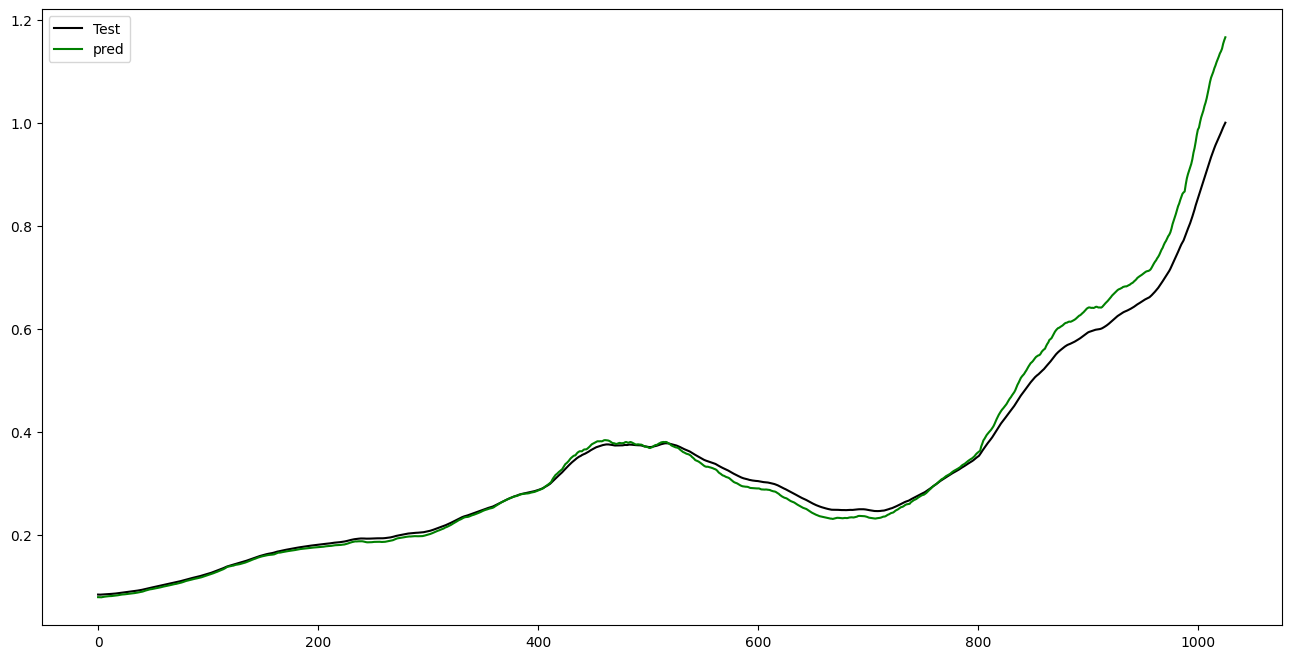

In [13]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()


Model2
Input Layer 8 inputs 
1 LSTM Layer with 192 neurons
3 dense layer with tanh activation
Output Layer Activation linear
Loss Function MSE
Batvh Size 15
Optimizer Adam 
Epocs 34


In [25]:
from keras.layers import Dense, Input, LSTM
from keras.models import Model
from keras import optimizers

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
lstm_output = LSTM(150, name='lstm_layer')(lstm_input)

dense_1 = Dense(64, activation='relu', name='dense_1')(lstm_output)
dense_2 = Dense(32, activation='relu', name='dense_2')(dense_1)
dense_3 = Dense(16, activation='relu', name='dense_3')(dense_2)

output = Dense(1, activation='linear', name='output')(dense_3)

model2 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model2.compile(optimizer=adam, loss='mse')

model2.fit(x=X_train, y=y_train, batch_size=15, epochs=34, shuffle=True, validation_split=0.1)


Epoch 1/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.1453e-04 - val_loss: 1.0406e-04
Epoch 2/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.4865e-06 - val_loss: 1.1163e-04
Epoch 3/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1.2754e-06 - val_loss: 9.5547e-05
Epoch 4/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1.3206e-06 - val_loss: 1.1652e-04
Epoch 5/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 7.6536e-07 - val_loss: 1.2107e-04
Epoch 6/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.8090e-06 - val_loss: 4.8351e-05
Epoch 7/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.9244e-06 - val_loss: 7.4119e-05
Epoch 8/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.6098e-06 - val_loss: 5.9287e-05
Epoch 9/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1.0052e-06 - val_loss: 6.1026e-05
Epoch 10/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.1376e-06 - val_loss: 4.2041e-05
Epoch 11/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions
y_train_pred_2= model2.predict(X_train)
y_test_pred_2 = model2.predict(X_test)

# Calculate metrics
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Training Metrics model2:")
print("MSE model2: ", mse_train)
print("RMSE model2: ", rmse_train)
print("MAE model2: ", mae_train)
print("R2 model2: ", r2_train)

print("\nTesting Metrics model2:")
print("MSEmodel2: ", mse_test)
print("RMSE model2: ", rmse_test)
print("MAE model2: ", mae_test)
print("R2 model2: ", r2_test)

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Training Metrics model2:
MSE model2:  1.785408155981064e-06
RMSE model2:  0.0013361916613948254
MAE model2:  0.0006365771226476213
R2 model2:  0.9973167252771132

Testing Metrics model2:
MSEmodel2:  0.0016029821486767532
RMSE model2:  0.04003725950507543
MAE model2:  0.022884861775223704
R2 model2:  0.9550669687081379


Model3
Input Layer 8 inputs 
1 LSTM Layer with 192 neurons
3 dense layer with sigmoid activation

In [19]:
from keras.layers import Dense

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
lstm_output = LSTM(192, name='lstm_layer')(lstm_input)

dense_1 = Dense(64, activation='sigmoid', name='dense_1')(lstm_output)
dense_2 = Dense(32, activation='sigmoid', name='dense_2')(dense_1)
dense_3 = Dense(16, activation='sigmoid', name='dense_3')(dense_2)

output = Dense(1, activation='linear', name='output')(dense_3)

model3 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model3.compile(optimizer=adam, loss='mse')

model3.fit(x=X_train, y=y_train, batch_size=15, epochs=34, shuffle=True, validation_split=0.1)


Epoch 1/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 5.8151e-04 - val_loss: 1.2864e-04
Epoch 2/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.5596e-06 - val_loss: 1.5130e-05
Epoch 3/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 6.4211e-06 - val_loss: 1.5121e-05
Epoch 4/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.4218e-06 - val_loss: 1.9990e-05
Epoch 5/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.3016e-06 - val_loss: 1.2649e-04
Epoch 6/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.4512e-06 - val_loss: 3.2608e-05
Epoch 7/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.7533e-06 - val_loss: 6.5445e-05
Epoch 8/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.1310e-06 - val_loss: 7.7930e-05
Epoch 9/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.3463e-06 - val_loss: 8.2968e-05
Epoch 10/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 5.7191e-06 - val_loss: 3.1229e-05
Epoch 11/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/

Model4
Input Layer 8 inputs 
1 LSTM Layer with 192 neurons
3 dense layer with tanh activation
Output Layer Activation Sigmoid
Loss Function MSE
Batvh Size 21
Optimizer SGD 
Epocs 55


In [21]:
from keras.layers import Dense

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
lstm_output = LSTM(192, name='lstm_layer')(lstm_input)

dense_1 = Dense(64, activation='tanh', name='dense_1')(lstm_output)
dense_2 = Dense(32, activation='tanh', name='dense_2')(dense_1)
dense_3 = Dense(16, activation='tanh', name='dense_3')(dense_2)

output = Dense(1, activation='sigmoid', name='output')(dense_3)

model4 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.SGD()
model4.compile(optimizer='adam', loss='msle')

model4.fit(x=X_train, y=y_train, batch_size=21, epochs=55, shuffle=True, validation_split=0.1)

Epoch 1/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0133 - val_loss: 0.0039
Epoch 2/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.1232e-04 - val_loss: 0.0039
Epoch 3/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.9460e-04 - val_loss: 0.0039
Epoch 4/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 2.6736e-04 - val_loss: 0.0038
Epoch 5/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 3.0254e-04 - val_loss: 0.0039
Epoch 6/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.9240e-04 - val_loss: 0.0039
Epoch 7/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 3.0451e-04 - val_loss: 0.0040
Epoch 8/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 2.9835e-04 - val_loss: 0.0039
Epoch 9/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 2.9925e-04 - val_loss: 0.0040
Epoch 10/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 2.9860e-04 - val_loss: 0.0039
Epoch 11/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 2.8576e-04 - val_loss: 0.0039
E

Comparing 4 models RMSE

In [23]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Make predictions for all models
y_train_pred_1 = model1.predict(X_train)
y_test_pred_1 = model1.predict(X_test)

y_train_pred_2 = model2.predict(X_train)
y_test_pred_2 = model2.predict(X_test)

y_train_pred_3 = model3.predict(X_train)
y_test_pred_3 = model3.predict(X_test)

y_train_pred_4 = model4.predict(X_train)
y_test_pred_4 = model4.predict(X_test)

# Calculate MSE for all models
mse_train_1 = mean_squared_error(y_train, y_train_pred_1)
mse_test_1 = mean_squared_error(y_test, y_test_pred_1)

mse_train_2 = mean_squared_error(y_train, y_train_pred_2)
mse_test_2 = mean_squared_error(y_test, y_test_pred_2)

mse_train_3 = mean_squared_error(y_train, y_train_pred_3)
mse_test_3 = mean_squared_error(y_test, y_test_pred_3)

mse_train_4 = mean_squared_error(y_train, y_train_pred_4)
mse_test_4 = mean_squared_error(y_test, y_test_pred_4)

# Calculate RMSE for all models
rmse_train_1 = np.sqrt(mse_train_1)
rmse_test_1 = np.sqrt(mse_test_1)

rmse_train_2 = np.sqrt(mse_train_2)
rmse_test_2 = np.sqrt(mse_test_2)

rmse_train_3 = np.sqrt(mse_train_3)
rmse_test_3 = np.sqrt(mse_test_3)

rmse_train_4 = np.sqrt(mse_train_4)
rmse_test_4 = np.sqrt(mse_test_4)

# Print RMSE for all models
print("RMSE Model1 (Train): ", rmse_train_1)
print("RMSE Model1 (Test): ", rmse_test_1)

print("RMSE Model2 (Train): ", rmse_train_2)
print("RMSE Model2 (Test): ", rmse_test_2)

print("RMSE Model3 (Train): ", rmse_train_3)
print("RMSE Model3 (Test): ", rmse_test_3)

print("RMSE Model4 (Train): ", rmse_train_4)
print("RMSE Model4 (Test): ", rmse_test_4)


129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
RMSE Model1 (Train):  0.0019610566286137818
RMSE Model1 (Test):  0.034224876332045406
RMSE Model2 (Train):  0.0013361916613948254
RMSE Model2 (Test):  0.04003725950507543
RMSE Model3 (Train):  0.002478508427106957
RMSE Model3 (Test):  0.18720750399724226
RMSE Model4 (Train):  0.02656920759411707
RMSE Model4 (Test):  0.3673427132560516


Model 2 has the lowest RMSE on the test set (0.0400), followed by Model 1 (0.0342), then Model 3 (0.1872), and finally Model 4 (0.3673).

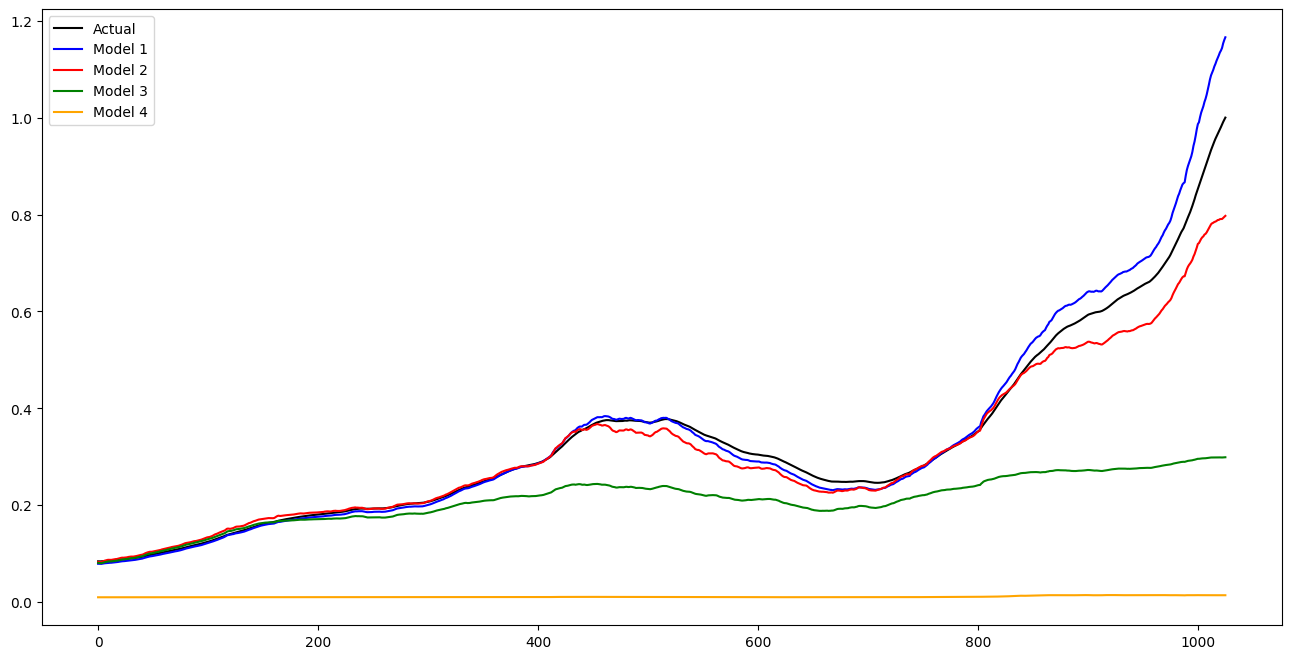

In [24]:
import matplotlib.pyplot as plt

# Assuming y_test_pred_1, y_test_pred_2, y_test_pred_3, y_test_pred_4 are predictions for test data for models 1, 2, 3, and 4 respectively

plt.figure(figsize=(16,8))
plt.plot(y_test, color='black', label='Actual')

# Plot predictions for all four models
plt.plot(y_test_pred_1, color='blue', label='Model 1')
plt.plot(y_test_pred_2, color='red', label='Model 2')
plt.plot(y_test_pred_3, color='green', label='Model 3')
plt.plot(y_test_pred_4, color='orange', label='Model 4')

plt.legend()
plt.show()


In conclusion, Model 2 exhibits strong performance based on the following specifications:

Input Layer: Accepts 8 inputs.
1 LSTM Layer: Consisting of 150 neurons.
3 Dense Layers: Each with hyperbolic tangent (tanh) activation.
Output Layer Activation: Linear activation function.
Loss Function: Mean Squared Error (MSE).
Batch Size: 15.
Optimizer: Adam.
Epochs: 34.